In [70]:
import sys
sys.path.append("..")
from loaders import imagenet_load
from importlib import reload
print(imagenet_load)
from conv import multigpu
from loaders.imagenet_load import orient
import conv
from conv import filter_gen, multigpu
from opt import ls
import numpy as np
from utils import misc
from numba import jit
misc.rreload(conv)
from imgaug import augmenters as iaa
from imgaug import imgaug
%pylab inline
import copy

<module 'loaders.imagenet_load' from '../loaders/imagenet_load.py'>
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['chararray', 'recarray', 'PackageLoader', 'show_config', 'format_parser', '__version__', 'record', 'pkgload', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [71]:
NUM_CLASSES = 10

In [72]:
def load_cifar_processed():
    npzfile = np.load("./cifar_processed")
    return (npzfile['XTrain'], npzfile['yTrain']), (npzfile['XTest'], npzfile['yTest'])

@jit(nopython=True)
def fast_exp(K):
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i,j] = math.exp(K[i,j])
    return K

In [7]:
(XTrain_p, labelsTrain), (XTest_p, labelsTest) = load_cifar_processed()

In [5]:
cifar_raw = np.load("/home/ubuntu/cifar_raw.npz")

In [73]:
XTrain = cifar_raw["X_train"]
XTest = cifar_raw["X_test"]
labelsTrain = cifar_raw["y_train"]
labelsTest = cifar_raw["y_test"]


In [432]:
np.max(np.abs(XTrain_p - X_train_processed))

7.7967815972135313e-05

In [9]:
X = np.concatenate((XTrain, XTest), axis=0)

In [61]:
X_p = np.concatenate((XTrain_p, XTest_p), axis=0)

In [300]:
%time gpu_handler = multigpu.MultiGpuHandler(16)

CPU times: user 36 ms, sys: 5.67 s, total: 5.7 s
Wall time: 6.1 s


In [301]:
%time gpu_handler.kill_all_gpu_processes()
%time gpu_handler.start_all()
%time gpu_handler.wait_for_all_gpu_init()

CPU times: user 16 ms, sys: 6.1 s, total: 6.11 s
Wall time: 21.8 s
CPU times: user 32 ms, sys: 5.41 s, total: 5.44 s
Wall time: 5.43 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.2 ms


In [302]:
def make_batch_augmenter(num_batches, seed=0):
    augmenters = []
    seqs = []
    random_state = np.random.RandomState(seed)
    def make_augmenter(idx):
        def augment(img, mode="HWC", **kwargs):
            if (mode == "CHW"):
                img = img.transpose(1,2,0)
            aug_im = seqs[idx].augment_image(img)
            
            if (mode == "CHW"):
                aug_im = aug_im .transpose(2,0,1)
            return aug_im
        return augment

    for batch in range(num_batches):
        seq = iaa.Sequential([iaa.Crop(px=(0, 8)), iaa.Fliplr(0.5)]).to_deterministic()
        seqs.append(seq)
        augmenters.append(make_augmenter(batch))
    return augmenters

def preprocess_batch_local(train, global_ZCA, whitening_means, min_divisor=1e-8, mode="CHW", *args, **kwargs):
    
    if (mode == "HWC"):
        train = train.transpose(0,3,1,2)

    origTrainShape = train.shape
    train = np.ascontiguousarray(train, dtype=np.float32).reshape(train.shape[0], -1)


    nTrain = train.shape[0]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)/55.0

    # Get rid of really small norms
    train_norms[np.where(train_norms < min_divisor)] = 1

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]

    train = (train - whitening_means).dot(global_ZCA)
    out = train.reshape(origTrainShape)
    
    if (mode == "HWC"):
        out = out.transpose(0,2,3,1)
    out = np.ascontiguousarray(out, dtype=out.dtype)
        
    return out



def preprocess_global(train, min_divisor=1e-8, zca_bias=0.1):
    origTrainShape = train.shape

    train = np.ascontiguousarray(train).reshape(train.shape[0], -1)


    nTrain = train.shape[0]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)/55.0

    # Get rid of really small norms
    train_norms[np.where(train_norms < min_divisor)] = 1

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]


    whitening_means = np.mean(train, axis=0)


    zeroCenterTrain = (train - whitening_means[np.newaxis, :])

    trainCovMat = 1.0/nTrain * zeroCenterTrain.T.dot(zeroCenterTrain)

    (E,V) = np.linalg.eig(trainCovMat)

    E += zca_bias
    sqrt_zca_eigs = np.sqrt(E)
    inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
    global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T)

    return global_ZCA, whitening_means







In [132]:
global_zca, whitening_means = preprocess_global(XTrain)

In [253]:
def make_preprocess_batch(global_zca, whitening_means, augmenters=None):
    def preprocess_batch(image_batch, **kwargs):
        fb = kwargs["feature_batch"]
        if (augmenters != None):
            aug_imgs = []
            for im in image_batch: 
                aug_imgs.append(augmenters[fb](im, **kwargs))
            image_batch = np.stack(aug_imgs, axis=0)
        return preprocess_batch_local(image_batch, global_ZCA=global_zca, whitening_means=whitening_means, **kwargs)
    return preprocess_batch

In [254]:
%time augmenters = make_batch_augmenter(1024)

CPU times: user 184 ms, sys: 84 ms, total: 268 ms
Wall time: 235 ms


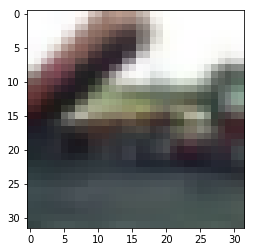

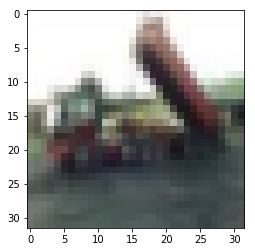

In [303]:
imshow(orient(augmenters[2](X[2], mode="CHW")))
plt.figure()
imshow(orient(X[2]))


In [256]:
preprocess_batch = make_preprocess_batch(global_zca, whitening_means, augmenters)

In [257]:
X_preprocess_augmented = preprocess_batch(X[:128], mode="CHW", feature_batch=0)

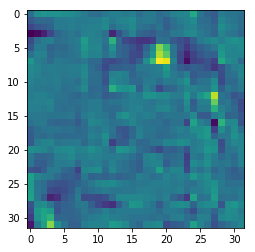

In [248]:
imshow(orient(X_preprocess_augmented[0])[:,:,0])

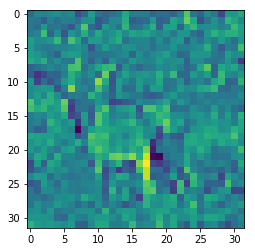

In [258]:
patches = filter_gen.patchify_all_imgs(XTrain_p, (6,6), pad=False)
patches = patches.reshape(patches.shape[0]*patches.shape[1],*patches.shape[2:])
patches = patches.transpose(0,3,1,2)

In [259]:
patches_mmap_loc = "/dev/shm/patches_cifar"
patches_mmap_data = np.memmap(patches_mmap_loc, mode="w+", shape=patches.shape, dtype=patches.dtype)
np.copyto(patches_mmap_data, patches)

patches_mmap_data.flush()
patches_mmap = multigpu.MmapArray(patches_mmap_data, mode="r+")

In [290]:
fg = filter_gen.make_empirical_filter_gen(patches_mmap, 1e-4, seed=0)

conv_args_template = \
{ 
  "filter_gen":fg,
  "num_feature_batches":16,
  "data_batch_size":128,
  "feature_batch_size":1024,
  "pool_size":15,
  "pool_type":"avg",
  "pool_stride":9,
  "patch_size":6,
  "pad":0,
  "bias":1,
  "conv_stride":1,
  "preprocess_batch": preprocess_batch
}

In [291]:
conv_args_template["preprocess_batch"]

<function __main__.make_preprocess_batch.<locals>.preprocess_batch>

In [292]:
imshow(seq.augment_image(imagenet_load.orient(XTrain[0])))
plt.figure()
imshow(imagenet_load.orient(XTrain[0]))

NameError: name 'seq' is not defined

In [293]:
X.dtype

dtype('uint8')

In [304]:
X_mmap_data = np.memmap("/dev/shm/cifar", mode="w+", dtype="uint8", shape=X.shape)
np.copyto(X_mmap_data, X)
X_mmap = multigpu.MmapArray(X_mmap_data, mode="r+")

mmap_out_shape = conv.conv_compute_output_shape(data=X_mmap, **conv_args_template)
X_out_data = np.memmap("/dev/shm/cifar_features", mode="w+", dtype="float32", shape=mmap_out_shape)
X_out_mmap = multigpu.MmapArray(X_out_data, mode="r+")

In [295]:
X_out_mmap.shape

(60000, 32768, 3, 3)

In [296]:
data_chunk_idxs = misc.chunk_idxs(X_out_data.shape[0], 16)

In [297]:
conv_args_template

{'bias': 1,
 'conv_stride': 1,
 'data_batch_size': 128,
 'feature_batch_size': 1024,
 'filter_gen': <function conv.filter_gen.make_empirical_filter_gen.<locals>.empirical_filter_gen>,
 'num_feature_batches': 16,
 'pad': 0,
 'patch_size': 6,
 'pool_size': 15,
 'pool_stride': 9,
 'pool_type': 'avg',
 'preprocess_batch': <function __main__.make_preprocess_batch.<locals>.preprocess_batch>}

In [305]:
gpu_results = []
for gpu, (sidx, eidx) in list(zip(gpu_handler.gpus, data_chunk_idxs)):
        conv_args = conv_args_template.copy()
        X_mmap_gpu = copy.copy(X_mmap)
        X_mmap_gpu.idxs = (sidx, eidx)
        X_out_gpu = copy.copy(X_out_mmap)
        X_out_gpu.idxs = (sidx, eidx)
        conv_args['data'] = X_mmap_gpu
        conv_args['output'] = X_out_gpu
        gpu_results.append(gpu.submit_async(conv.conv_mmap, **conv_args))

for gpu_result in gpu_results:
    %time gpu_result.result()

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 2min 7s
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 17.1 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 203 µs
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 197 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 887 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 14.2 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 194 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.64 s
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 9.31 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 392 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 9.42 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 198 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 189 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.01 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 334 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time

In [306]:
X_out_data

memmap([[[[ 1.5971607 ,  2.84237576,  5.40018272],
         [ 2.68095422,  3.52644634,  4.69831848],
         [ 4.72235584,  3.81340194,  5.02967691]],

        [[ 2.93494654,  4.06263638,  3.22431111],
         [ 3.89460611,  4.27173471,  2.86119628],
         [ 3.25234675,  3.55353355,  2.99930358]],

        [[ 1.83358514,  2.40267277,  2.08479786],
         [ 3.67329717,  3.06080937,  3.29363465],
         [ 4.42097282,  3.34529543,  3.16258693]],

        ..., 
        [[ 0.60239017,  1.72884572,  1.7914691 ],
         [ 1.12335193,  1.38416982,  1.31598711],
         [ 2.1753695 ,  1.34078908,  1.25684524]],

        [[ 1.63618207,  1.24903405,  0.65545517],
         [ 1.44682705,  1.05900788,  0.59978873],
         [ 0.58293557,  0.5637877 ,  0.58236098]],

        [[ 0.79601097,  1.11983097,  1.28097868],
         [ 1.18724692,  1.22551858,  0.97935766],
         [ 0.69691002,  0.78543097,  0.68364865]]],


       [[[ 3.66970825,  4.2156148 ,  3.78280044],
         [ 4.53996992

In [307]:
X_out_data

memmap([[[[ 1.5971607 ,  2.84237576,  5.40018272],
         [ 2.68095422,  3.52644634,  4.69831848],
         [ 4.72235584,  3.81340194,  5.02967691]],

        [[ 2.93494654,  4.06263638,  3.22431111],
         [ 3.89460611,  4.27173471,  2.86119628],
         [ 3.25234675,  3.55353355,  2.99930358]],

        [[ 1.83358514,  2.40267277,  2.08479786],
         [ 3.67329717,  3.06080937,  3.29363465],
         [ 4.42097282,  3.34529543,  3.16258693]],

        ..., 
        [[ 0.60239017,  1.72884572,  1.7914691 ],
         [ 1.12335193,  1.38416982,  1.31598711],
         [ 2.1753695 ,  1.34078908,  1.25684524]],

        [[ 1.63618207,  1.24903405,  0.65545517],
         [ 1.44682705,  1.05900788,  0.59978873],
         [ 0.58293557,  0.5637877 ,  0.58236098]],

        [[ 0.79601097,  1.11983097,  1.28097868],
         [ 1.18724692,  1.22551858,  0.97935766],
         [ 0.69691002,  0.78543097,  0.68364865]]],


       [[[ 3.66970825,  4.2156148 ,  3.78280044],
         [ 4.53996992

In [308]:
np.sum(X_out_data == 0)/(len(X_out_data.ravel()))

0.0018745798181604456

In [268]:
np.sum(X_out_data == 0)/(len(X_out_data.ravel()))

0.002561430302372685

In [309]:
%time X_train_lift = X_out_data.reshape(X_out_data.shape[0], -1)[:50000, :].astype('float64')
%time X_test_lift = X_out_data.reshape(X_out_data.shape[0], -1)[50000:, :].astype('float64')

CPU times: user 13.2 s, sys: 26.4 s, total: 39.6 s
Wall time: 39.6 s
CPU times: user 2.79 s, sys: 5.25 s, total: 8.04 s
Wall time: 8.04 s


In [310]:
num_feats = conv_args_template["num_feature_batches"]*conv_args_template["feature_batch_size"]*9*2

In [311]:
X_train_lift /= np.sqrt(num_feats)
X_test_lift /= np.sqrt(num_feats)

In [312]:
X_train_lift.shape

(50000, 294912)

In [313]:
%time K_train = X_train_lift.dot(X_train_lift.T)
%time K_test =  X_test_lift.dot(X_train_lift.T)

CPU times: user 6h 13min 51s, sys: 2h 42min 23s, total: 8h 56min 14s
Wall time: 22min 2s
CPU times: user 2h 38min 7s, sys: 1h 4min 44s, total: 3h 42min 52s
Wall time: 7min 1s


In [317]:
results = {}
for reg in [1e-3]:
    %time acc = ls.trainAndEvaluateDualModel(KTrain=K_train, KTest=K_test, labelsTrain=labelsTrain, labelsTest=labelsTest, reg=reg)
    print(acc)
    results[reg] = acc


Learning Dual Model
reg is 0.001
CPU times: user 28min 27s, sys: 8min 26s, total: 36min 54s
Wall time: 8min 5s
(0.99995999999999996, 0.79679999999999995, array([[  67.21829481,  -62.02695716,  -28.48001406, ...,  -59.26889989,
          -6.04534226,   -0.54845808],
       [  -9.16914123,  -31.49043109,  -50.28975243, ...,    6.61723133,
          52.93583268,   86.98948598],
       [  -8.18697596,  -23.8871796 ,  -45.17165199, ...,  -71.7573571 ,
        -112.14381074,  206.21626152],
       ..., 
       [ -21.02542212,   25.643124  ,   48.39120927, ...,   30.42891163,
        -163.14267785,  130.44734886],
       [ -45.38631395,  -14.47179019,    6.23175659, ...,   54.66547156,
          66.1587717 ,  -45.72277314],
       [-102.07633342,  113.14791494,   25.95643042, ...,   -5.81288209,
         -34.4232363 ,  -70.02267477]]))


In [498]:
X_fresh_p = preprocess_batch(X)

In [501]:
X_fresh_p

array([[[[ -5.10424211e-01,  -1.01882055e+00,  -9.80779942e-01, ...,
            4.35284400e-01,   3.80424943e-01,   3.36178019e-01],
         [ -1.54031831e+00,  -1.76911237e+00,  -1.38736690e+00, ...,
           -2.19687069e-02,   5.17908586e-02,   3.91260500e-01],
         [ -1.03158641e+00,  -1.17598410e+00,  -4.64243769e-01, ...,
           -1.01416845e-01,   3.60240730e-01,   1.24516239e-01],
         ..., 
         [  5.42084381e-01,   9.48062501e-01,   8.21983553e-01, ...,
            1.09863164e+00,  -1.94313321e+00,  -1.17046312e+00],
         [ -3.03322192e-01,  -2.62558931e-02,   4.93861040e-01, ...,
            2.04208351e+00,  -8.28547301e-01,  -5.97102856e-01],
         [ -5.56354861e-01,  -6.62061594e-01,  -3.15659344e-01, ...,
            2.41413336e+00,   2.46644750e-01,  -2.15897601e-01]],

        [[  2.85360202e-01,  -9.17983964e-02,  -1.77091412e-01, ...,
            4.87995604e-01,   3.14464071e-01,   3.14587102e-01],
         [ -5.89552643e-01,  -8.74873533e-01,

In [504]:
np.mean(np.abs(X_p - X_fresh_p))

3.2582531564852581e-06

In [276]:
K_train_256 = np.load("/home/ubuntu/cifar_kernels/KTrain_256_patches.npy")
K_test_256 = np.load("/home/ubuntu/cifar_kernels/KTest_256_patches.npy")

In [57]:
results_256 = {}
for reg in [1e-2, 1e-3, 1e-4]:
    acc = ls.trainAndEvaluateDualModel(KTrain=K_train_256, KTest=K_test_256, labelsTrain=labelsTrain, labelsTest=labelsTest, reg=reg)
    print(acc)
    results_256[reg] = acc


Learning Dual Model
reg is 0.01
(0.99985999999999997, 0.84740000000000004, array([[ -3.35480199,  -2.91510599,  -3.00231609, ...,  -3.96316318,
          3.08084399,   7.44949294],
       [ -0.29215553,  -2.26995122,   6.83913934, ...,  -1.80165119,
         -4.55425765,   6.74723685],
       [ -7.04050356,  -1.74000851, -10.98937311, ...,  -8.01983104,
         -5.72820576,  25.94227243],
       ..., 
       [ -6.8387073 ,  -0.07271528,   3.74946065, ...,  -0.09115042,
         -9.92378035,  18.7213747 ],
       [ -2.93466858,   7.04252265,   0.20085643, ...,  -2.29092793,
         -0.5178039 ,  -9.19902159],
       [ -6.70482668,  20.37677055,  -2.28010135, ...,  -5.13080746,
         -3.3058487 ,  -8.78801842]]))
Learning Dual Model
reg is 0.001
(1.0, 0.83919999999999995, array([[ -9.90938685,  -2.51302121,  -3.45947151, ...,  -2.4066732 ,
          4.79007306,  12.63961259],
       [  1.16845315,  -2.2500285 ,  15.58721177, ...,  -0.66687891,
        -11.08140975,   8.64197644],
  

In [315]:
%time K_train_combine = K_train_256 + K_train
%time K_test_combine = K_test_256 + K_test

CPU times: user 5.23 s, sys: 4.73 s, total: 9.96 s
Wall time: 9.96 s
CPU times: user 1.38 s, sys: 5.72 s, total: 7.1 s
Wall time: 7.1 s


In [316]:
results_combine = {}
for reg in [1e-2]:
    acc = ls.trainAndEvaluateDualModel(KTrain=K_train_combine, KTest=K_test_combine, labelsTrain=labelsTrain, labelsTest=labelsTest, reg=reg)
    print(acc)
    results_combine[reg] = acc


Learning Dual Model
reg is 0.01
(0.99994000000000005, 0.84219999999999995, array([[ -0.95998592,  -3.22372551,  -3.28267448, ...,  -4.28763624,
          2.06771383,   4.67526008],
       [ -0.47662129,  -2.91781213,   3.28190904, ...,  -2.3190141 ,
          0.30876553,   6.84332601],
       [ -5.46871822,  -1.611581  ,  -6.7880167 , ...,  -9.16258737,
         -5.39158408,  22.17576212],
       ..., 
       [ -4.01867923,  -0.30428117,   2.69888125, ...,   2.74020849,
         -7.7706932 ,  11.81054449],
       [ -2.65328261,   3.16204324,  -0.40339256, ...,  -0.38081278,
          1.87607948,  -6.94064027],
       [ -7.90046198,  13.80692904,   1.21665931, ...,  -2.15633645,
         -0.71495726,  -9.23971422]]))
